In [1]:
import numpy as np
import pandas as pd
import random
import itertools
import matplotlib.pyplot as plt
import plotly.express as px
import glob
import spacy
import sklearn
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib
import io
import base64
from IPython.display import display_html
from itertools import chain, cycle
import sys
sys.path.append('../../../../utils')
sys.path.append('..')
import gezi
from gezi import tqdm
from src.eval import *
from src.util import *
from src import config
from src.visualize import *
pd.set_option('display.float_format', lambda x: '%.02f' % x)

In [2]:
# https://www.kaggle.com/kaggleqrdl/oof-vrs-valid-eda

In [3]:
#https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side
def display_side_by_side(*args):
  tds = "text-align:left; border-left: 1px solid #000;border-right: 1px solid #000;"
  html_str=''
  wd = int(100/len(args))
  for df, title in args:
    html_str+=f'<td style="{tds}min-width: {wd}%;width: {wd}%;">'
    html_str+=f'<b>{title}</b><br>{df}'
    html_str+='</td>'
  display_html("<table style='border: 1px solid black;'>"+html_str+"</table>",raw=True)

In [4]:
#stolen from https://www.kaggle.com/raghavendrakotala/fine-tunned-on-roberta-base-as-ner-problem-0-533 
def oof_init(validcsv='../input/feedback-prize-2021/train.csv', oofcsv='../working/offline/44/valid_pred.csv', feedbackdir="../input/feedback-prize-2021"):
  global train_texts, valid, oof
  train_names, train_texts = [], [] 
  train_texts = pd.read_feather(f'{feedbackdir}/texts.fea') 
  #import dataset with valid (subset of train, holdout for CV) and oof (predictions for valid set)
  valid = pd.read_csv(validcsv)
  oof = pd.read_csv(oofcsv)
  oof['oof_discourse_id'] = range(len(oof)) #i find this more clear than index
  oof["pred_len"] = oof["predictionstring"].apply(lambda x: len(x.split()))
  valid["pred_len"] = valid["predictionstring"].apply(lambda x: len(x.split()))
  oof["start"] = oof["predictionstring"].apply(lambda x: int(x.split()[0]))
  oof["end"] = oof["predictionstring"].apply(lambda x: int(x.split()[-1]))
  valid["start"] = valid["predictionstring"].apply(lambda x: int(x.split()[0]))
  valid["end"] = valid["predictionstring"].apply(lambda x: int(x.split()[-1]))
  valid["pred_len"] = valid["predictionstring"].apply(lambda x: len(x.split()))
  print(f"Train Texts Shape {np.shape(train_texts)}  OOF Shape {np.shape(oof)} Valid Shape {np.shape(valid)} ")
  return oof, valid, train_texts

In [5]:
def show_lengths(oof, valid):
  def get_html(train, dtn):
    #print("get_html:", train.keys())
    df = train.groupby(dtn).mean()[['pred_len', 'start', 'end']]
    #display(df)
    df.insert(0, "count", train.groupby(dtn).count()['id'])
    df.insert(0, "perc", df['count']/len(train))
    #print(df.keys())
    df.loc['Column_TotalOrMean'] = df.sum(numeric_only=True, axis=0)
    df.loc['Column_TotalOrMean']['pred_len'] = df['pred_len'].mean()
    df.loc['Column_TotalOrMean']['start'] = df['start'].mean()
    df.loc['Column_TotalOrMean']['end'] = df['end'].mean()
    return df.to_html()
  display_side_by_side((get_html(oof, "class"), "oof class perc, counts and avg lengths "), (get_html(valid, "discourse_type"), "valid type perc, counts and avg lengths"))

In [6]:
oof, valid, train_texts = oof_init()

Train Texts Shape (15594, 3)  OOF Shape (140095, 7) Valid Shape (144293, 11) 


In [7]:
show_lengths(oof, valid)

,perc,count,pred_len,start,end
class,,,,,
Claim,0.33,46716.00,16.54,129.42,144.96
Concluding Statement,0.10,13821.00,63.18,375.15,437.33
Counterclaim,0.04,5399.00,22.65,253.71,275.36
Evidence,0.32,45502.00,82.21,190.16,271.35
Lead,0.07,9300.00,51.50,1.36,51.86
Position,0.11,15383.00,16.70,41.70,57.39
Rebuttal,0.03,3974.00,24.73,298.64,322.37
Column_TotalOrMean,1.00,140095.00,69.38,322.53,390.15
,perc,count,pred_len,start,end


In [8]:
res = calc_metrics(valid, oof)

calc_f1:   0%|          | 0/7 [00:00<?, ?it/s]

In [9]:
res

{'f1/Overall': 0.7133371193737977,
 'f1/Claim': 0.6788470267816614,
 'acc/Claim': 0.7041713931040386,
 'recall/Claim': 0.6552809257304467,
 'cm/Claim': array([[32901, 13822],
        [17308, 29415]]),
 'f1/Evidence': 0.7771479942552049,
 'acc/Evidence': 0.7787958690397715,
 'recall/Evidence': 0.7755070783099578,
 'cm/Evidence': array([[35443, 10067],
        [10260, 35250]]),
 'f1/Position': 0.7302947669133879,
 'acc/Position': 0.7311492459698388,
 'recall/Position': 0.7294422827496757,
 'cm/Position': array([[11248,  4136],
        [ 4172, 11212]]),
 'f1/Concluding Statement': 0.8717066744730679,
 'acc/Concluding Statement': 0.8617421501953407,
 'recall/Concluding Statement': 0.8819043388123797,
 'cm/Concluding Statement': array([[11911,  1911],
        [ 1595, 12227]]),
 'f1/Lead': 0.8386091255978932,
 'acc/Lead': 0.8388345339210838,
 'recall/Lead': 0.8383838383838383,
 'cm/Lead': array([[7802, 1499],
        [1504, 7797]]),
 'f1/Counterclaim': 0.5888750222856124,
 'acc/Counterclaim'

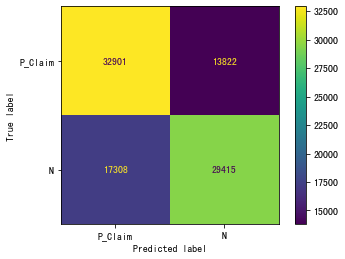

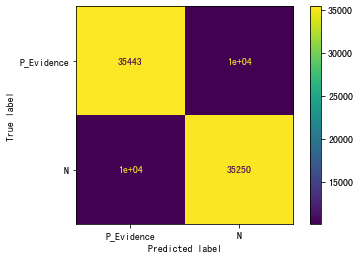

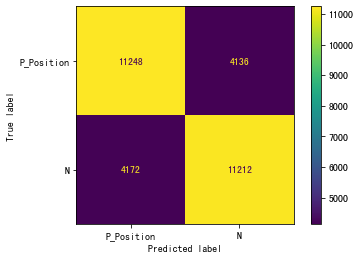

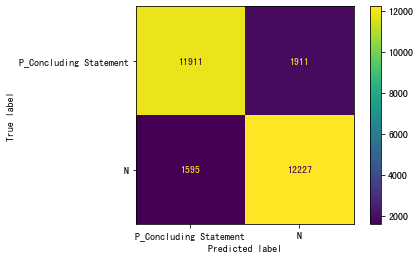

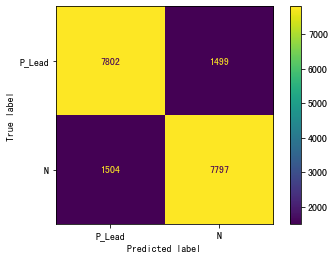

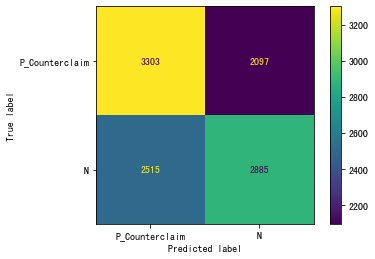

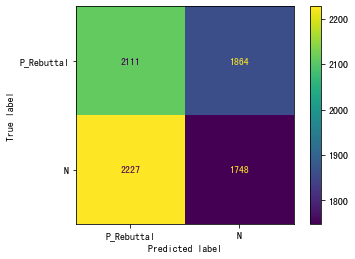

In [15]:
for cls in CLASSES:
  sklearn.metrics.ConfusionMatrixDisplay(res[f'cm/{cls}'], [f'P_{cls}', 'N']).plot()